Importing libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from pa3_demo import load_obj_each_frame, draw_target_object_center

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


#### Data Preparation

From the annotation file, it can be seen that a large portion of the position data are missing (i.e: [-1, -1]).  Therefore, we will need to interpolate the position data to fill in the missing values.

In [9]:
VIDEO_FILE = "./commonwealth.mp4"
JSON_PATH = "./object_to_track.json"
frame_dict = load_obj_each_frame(JSON_PATH)

count_missing = 0
# count the number of (-1, -1) in the json file
for i, pos in enumerate(frame_dict["obj"]):
    if pos == [-1, -1]:
        count_missing += 1

print(f"Number of missing frames: {count_missing} out of {len(frame_dict['obj'])} frames")

cap = cv.VideoCapture(VIDEO_FILE)
frames_count, fps, width, height = cap.get(cv.CAP_PROP_FRAME_COUNT), cap.get(cv.CAP_PROP_FPS), cap.get(cv.CAP_PROP_FRAME_WIDTH), cap.get(cv.CAP_PROP_FRAME_HEIGHT)
print(f"Frames per second: {fps}")
print(f"Frame width: {width}")
print(f"Frame height: {height}")
xs = [xy[0] for xy in frame_dict["obj"]]
ys = [xy[1] for xy in frame_dict["obj"]] #  if xy[0] != -1

assert len(xs) == len(ys) == frames_count

Number of missing frames: 168 out of 249 frames
Frames per second: 30.0
Frame width: 1920.0
Frame height: 1080.0


#### Kalman Filter
Reference: 
1. [Wikipedia](https://en.wikipedia.org/wiki/Kalman_filter)
2. [Blog](https://machinelearningspace.com/object-tracking-python/)

Per iterations Kalman filter has three stages :
1. Prediction : Apply the state transition matrix $F_k$ on the previous state $x_{k-1}$ to get the predicted state $x_{k|k-1}$
2. Kalman Gain : Calculate the Kalman gain, $K[k]$, which is used to weigh the difference between the predicted state and the actual state.
3. Estimation : Update the state estimate using the prediction, Kalman gain, and current measurement.

As in the `alpha-beta filter`, in our particular 2D case, we use Newton's laws of motions to compute the current position and velocity of the object. Thus: 
$$ 
{x}_k = x_{k-1} + \Delta t \cdot v_{k-1} + u_k
$$

The measurement model is given by:
$$
z_k = x_k + w_k
$$

Since Kalman filter considers some noise process in the modeling framework, we have consider both a process noise  and a measurement noise. In our equations, \textbf{w}_k and \textbf{v}_k represent the process noise vector with the covariance $Q$ and the measurement noise vector with the covariance $R$, respectively. They are assumed statistically independence Gaussian noise with the normal probability distribution. Similarly the state transition matrix is given by $F_k$, and the measurement matrix is given by $H_k$. So we can update the prediction equation as:
$$
{x}_{k} = F_k \cdot x_{k-1} + u_k
$$
And the measurement equation as:
$$
z_k = H_k \cdot{x}_{k} + w_k
$$

We then calculate the state covariance matrix $P_k$, which represents the uncertainty of the state estimate. 
$$
P_k = F_k \cdot P_{k-1} \cdot F_k^T + Q
$$

During update stage, we first calculate the residual, which is the difference between the actual measurement and the predicted measurement:
$$
r_k = z_k - H_k \cdot x_k
$$



This is followed by the Kalman gain calculation:
$$
K_k = P_k \cdot H_k^T \cdot (H_k \cdot P_k \cdot H_k^T + R)^{-1}
$$

Finally, we update the state estimate and the state covariance matrix:
$$
x_k = x_k + K_k \cdot r_k
$$
$$
P_k = (1 - K_k \cdot H_k) \cdot P_k
$$




In [11]:
def kalman_filter(measurements: list, starting_pos: float, starting_vel: float, state_noise: float, measurement_noise: float, time_step: float) -> np.ndarray:
    """https://en.wikipedia.org/wiki/Kalman_filter#Example_application,_technical
    Implantation of Kalman filter for 2d object tracking
    Args:
        measurements (list): list of measurements
        starting_pos (float): initial position
        starting_vel (float): initial velocity
        state_noise (float): state noise
        measurement_noise (float): measurement noise
        time_step (float): time step
    
    Returns:
        np.ndarray: filtered result
    """
    # Initial state
    x_prev = starting_pos
    v_prev = starting_vel
    filtered_res = []
    state = np.array([x_prev, v_prev])

    # state transition matrix
    F = np.array([[1, time_step],
                    [0, 1]])
    
    # measurement matrix
    H = np.array([[1, 0]])

    # covariance identity matrix
    P = np.eye(2)

    # state noise covariance matrix
    Q = np.array([[state_noise, 0],
                    [0, state_noise]])
    
    # measurement noise covariance matrix
    R = np.array([[measurement_noise]])

    for measure in measurements:


        # Prediction Step 
        current_state = np.dot(F, state)
        P = np.dot(np.dot(F, P), F.T) + Q

        if measure == -1:
            state = np.dot(F, state)
        else:
            # Update Step
            residual = measure - np.dot(H, current_state)
            # kalman gain
            K = np.dot(P, H.T) / (np.dot(np.dot(H, P), H.T) + R)
            state = current_state + np.dot(K, residual)
            P = np.dot((np.eye(2) - np.dot(K, H)), P)
        filtered_res.append(state[0])
    return np.array(filtered_res)


#### Plotting and Visualization

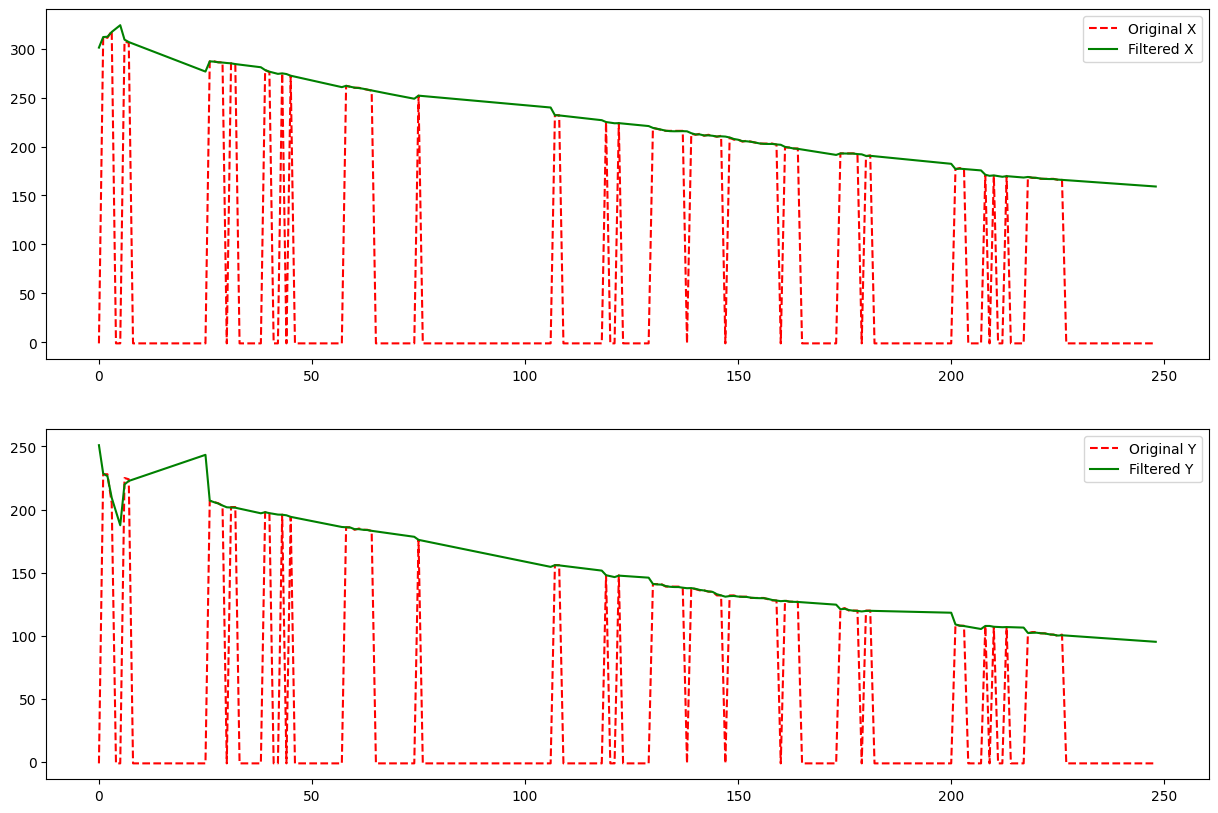

In [12]:
START_X = 300
START_Y = 250
STATE_NOISE = 0.01
MEASUREMENT_NOISE = 0.1

# Predicted X positions
pred_xpos_kalman = kalman_filter(measurements=xs,
                                 starting_pos=START_X,
                                 starting_vel=1.,
                                 state_noise=STATE_NOISE,
                                 measurement_noise=MEASUREMENT_NOISE,
                                 time_step=1)

# Predicted Y positions
pred_ypos_kalman = kalman_filter(measurements=ys,
                                 starting_pos=START_Y,
                                 starting_vel=1.,
                                 state_noise=STATE_NOISE,
                                 measurement_noise=MEASUREMENT_NOISE,
                                 time_step=1)

plt.figure(figsize=(15, 10))
# Plot the original and filtered X positions
plt.subplot(2, 1, 1)
plt.plot(xs, "r--", label="Original X")
plt.plot(pred_xpos_kalman, "g-", label="Filtered X")
plt.legend()

# Plot the original and filtered Y positions
plt.subplot(2, 1, 2)
plt.plot(ys, "r--", label="Original Y")
plt.plot(pred_ypos_kalman, "g-", label="Filtered Y")
plt.legend()


In [14]:
predictions = list([x, y] for x, y in zip(pred_xpos_kalman, pred_ypos_kalman))
draw_target_object_center(video_file=VIDEO_FILE, obj_centers=predictions, output_file="part_1_demo.mp4")

In [15]:
# def convert predictions to submission format
submission = {"obj": predictions}
import json
with open("part_1_object_tracking.json", "w") as f:
        json.dump(submission, f)